In [2]:
import os
os.chdir("/workspaces/BAIT")

In [3]:
import pandas as pd


df_baselines = pd.read_csv("analysis/results/results.csv")
df_baselines["phase_1_strategy"].fillna("Baseline", inplace=True)
df_baselines = df_baselines[df_baselines["phase_1_strategy"] == "Baseline"]
df_baselines = df_baselines[["file", "phase_0_strategy", "final_sparsity", "accuracy", "phase_0_type"]]
df_baselines = df_baselines.groupby(["file", "phase_0_strategy", "phase_0_type", "final_sparsity"]).mean().reset_index()


#one shot baselines only for a start
df_baselines = df_baselines[df_baselines["phase_0_type"] == "PruningPhase"]
df_baselines

,file,phase_0_strategy,phase_0_type,final_sparsity,accuracy
0,baseline_grasp_0.005_0_20220424161738749464.pt,grasp,PruningPhase,0.005,37.54
1,baseline_grasp_0.005_1_20220424161738749464.pt,grasp,PruningPhase,0.005,27.64
3,baseline_grasp_0.01_0_20220424161738749464.pt,grasp,PruningPhase,0.010,83.64
4,baseline_grasp_0.01_1_20220424161738749464.pt,grasp,PruningPhase,0.010,84.29
6,baseline_grasp_0.05_0_20220424161738749464.pt,grasp,PruningPhase,0.050,95.37
...,...,...,...,...,...
167,baseline_oneshot_synflow_0.1_1_202204260826167...,synflow,PruningPhase,0.100,96.50
168,baseline_oneshot_synflow_0.1_2_202204260826167...,synflow,PruningPhase,0.100,96.30
169,baseline_oneshot_synflow_0.2_0_202204260745322...,synflow,PruningPhase,0.200,97.20
170,baseline_oneshot_synflow_0.2_1_202204260745322...,synflow,PruningPhase,0.200,96.91


# Load States

In [4]:
from utils.state import State
from utils.state import prepare_data
import os
from tqdm import tqdm
from typing import List
# data loader will be cached for performance
DATA_LOADERS = {}
def load_state(file) -> State:
    s = State()
    s.load(file, load_data=False)
    try:
        s.test_loader = DATA_LOADERS[s.config.data_params.dataset]
    except:
        prepare_data(s, s.config.data_params)
        DATA_LOADERS[s.config.data_params.dataset] = s.test_loader
    return s

states = {}
for file in tqdm(df_baselines["file"]):
    s = load_state(file)

    masks = [mask for mask, _ in s.pruner.masked_parameters]
    final_weights = [param for name, param in s.model.named_parameters() if name.endswith(".weight")]
    initial_weights = [param for name, param in s.initial_state.model.named_parameters() if name.endswith(".weight")]

    states[file] = {f"layer_{i}": {"mask": m, "final_weights": fw, "initial_weights": iw} for i,  (m, fw, iw) in enumerate(zip(masks, final_weights, initial_weights))}

  0%|          | 0/92 [00:00<?, ?it/s]

Loading mnist dataset.


100%|██████████| 92/92 [00:04<00:00, 20.71it/s]


# Analysis

Ideas:
- Average value of pruned and unpruned weights, separate histograms for initial and final weights
- calculate movement from initial to final weights, histogram pruned and unpruned weights
- 

In [11]:
states["baseline_grasp_0.005_0_20220424161738749464.pt"]["layer_0"]["mask"]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [5]:
import torch
mask = states["baseline_grasp_0.005_0_20220424161738749464.pt"]["layer_0"]["mask"].cpu()
final_weights = torch.tensor(states["baseline_grasp_0.005_0_20220424161738749464.pt"]["layer_0"]["final_weights"].cpu(),requires_grad=True).detach().numpy()
initial_weights = torch.tensor(states["baseline_grasp_0.005_0_20220424161738749464.pt"]["layer_0"]["initial_weights"].cpu(),requires_grad=True).detach().numpy()

/tmp/ipykernel_278361/238882405.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_weights = torch.tensor(states["baseline_grasp_0.005_0_20220424161738749464.pt"]["layer_0"]["final_weights"].cpu(),requires_grad=True).detach().numpy()
/tmp/ipykernel_278361/238882405.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_weights = torch.tensor(states["baseline_grasp_0.005_0_20220424161738749464.pt"]["layer_0"]["initial_weights"].cpu(),requires_grad=True).detach().numpy()


In [6]:
mask.shape, final_weights.shape, initial_weights.shape

(torch.Size([100, 784]), (100, 784), (100, 784))

In [14]:
df_m = pd.DataFrame(mask)
df_fw = pd.DataFrame(final_weights)
df_iw = pd.DataFrame(initial_weights)

<AxesSubplot:>

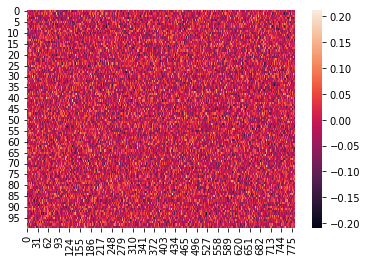

In [18]:
import seaborn as sns
sns.heatmap(df_iw)

<AxesSubplot:>

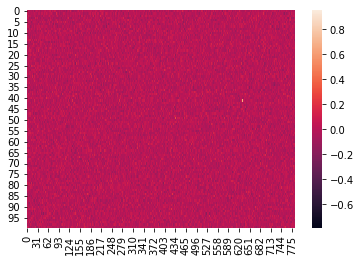

In [19]:
sns.heatmap(df_fw)

In [46]:
df_pruned = df_fw * df_m
df_pruned = df_fw.T
df_pruned

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.003008,-0.021750,-0.053563,0.033595,-0.039943,-0.048408,0.025163,-0.103846,-0.002961,0.022002,...,-0.030477,0.028854,0.016098,0.001832,0.081172,-0.000228,-0.003919,-0.030606,0.001830,0.020488
1,0.019105,0.077668,-0.060629,0.045684,-0.054163,0.037050,0.032929,0.064691,-0.030621,0.082275,...,0.077591,0.064344,0.017942,0.039342,0.000513,0.004898,0.047882,0.064546,-0.071266,0.061799
2,0.049541,0.013975,-0.065266,-0.022940,0.037748,-0.078526,0.021812,-0.048072,0.049064,-0.037751,...,-0.032741,0.010079,0.027356,-0.035340,-0.034893,-0.095651,-0.121910,0.066385,0.055179,-0.058930
3,0.010706,0.004802,-0.017125,-0.091078,0.103009,0.078423,-0.018926,0.030410,-0.003937,-0.012098,...,-0.091520,0.005164,-0.031333,0.019218,0.086570,-0.039974,-0.011292,-0.069186,-0.021423,0.030514
4,0.022784,-0.009972,0.103449,0.039383,-0.006035,0.039651,-0.024505,0.057918,-0.065342,-0.061203,...,0.006878,0.014926,-0.040706,-0.026647,-0.024722,-0.030045,-0.014639,-0.070886,0.024323,0.042704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,0.048353,0.078156,0.061688,-0.006506,0.039172,-0.048566,-0.100928,-0.045690,0.087290,-0.010184,...,-0.011480,0.016727,0.148582,0.036835,0.030809,-0.038196,-0.005027,0.062860,0.026978,-0.002410
780,0.007503,0.012174,0.071376,-0.117292,-0.006003,-0.021371,0.014729,0.047113,-0.001342,0.002231,...,-0.039468,-0.035066,0.023991,0.020314,0.013523,-0.067785,-0.028471,0.016926,0.034633,0.037587
781,0.049760,-0.052205,0.047823,0.025499,-0.050418,0.101261,-0.027356,0.013907,0.007732,0.056454,...,0.063038,0.053657,0.040101,-0.104690,0.021785,0.047260,-0.022196,0.042939,-0.057292,-0.040180
782,-0.007038,-0.043182,0.049577,-0.092898,0.044000,-0.020477,-0.046760,0.013124,-0.045139,-0.051386,...,-0.020724,-0.012192,0.020223,-0.014354,-0.015771,-0.036398,-0.006550,-0.038440,0.023422,-0.062176
